In [48]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [49]:
# Split data into training/validation and test sets based on dates
train_val_start_date = '2000-01-31'
test_start_date = '2018-08-31'
test_end_date = '2020-08-31'

In [50]:
stock_name = 'XRM'
file_path_1 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_CRSP_daily_data_alltime.csv' # Daily technical data (CRSP)

df = pd.read_csv(file_path_1)

df['date'] = pd.to_datetime(df['date'])  # CRSP daily data
df = df[(df['date'].dt.year >= 2016)].copy()
df.index = range(len(df))

df.head()

,PERMNO,date,TICKER,BIDLO,ASKHI,PRC,VOL,RET,OPENPRC
0,11850,2016-01-04,XOM,76.4550,77.94,77.46,20400084.0,-0.006286,77.50
1,11850,2016-01-05,XOM,76.9223,78.14,78.12,11993500.0,0.008521,77.19
2,11850,2016-01-06,XOM,76.5900,77.64,77.47,18826900.0,-0.008321,76.64
3,11850,2016-01-07,XOM,75.9000,77.99,76.23,21263761.0,-0.016006,76.06
4,11850,2016-01-08,XOM,74.5000,76.65,74.69,19033628.0,-0.020202,76.35


In [51]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.date,
                      open=df.OPENPRC,
                      high=df.ASKHI,
                      low=df.BIDLO,
                      close=df.PRC,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.date, y=df.VOL, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

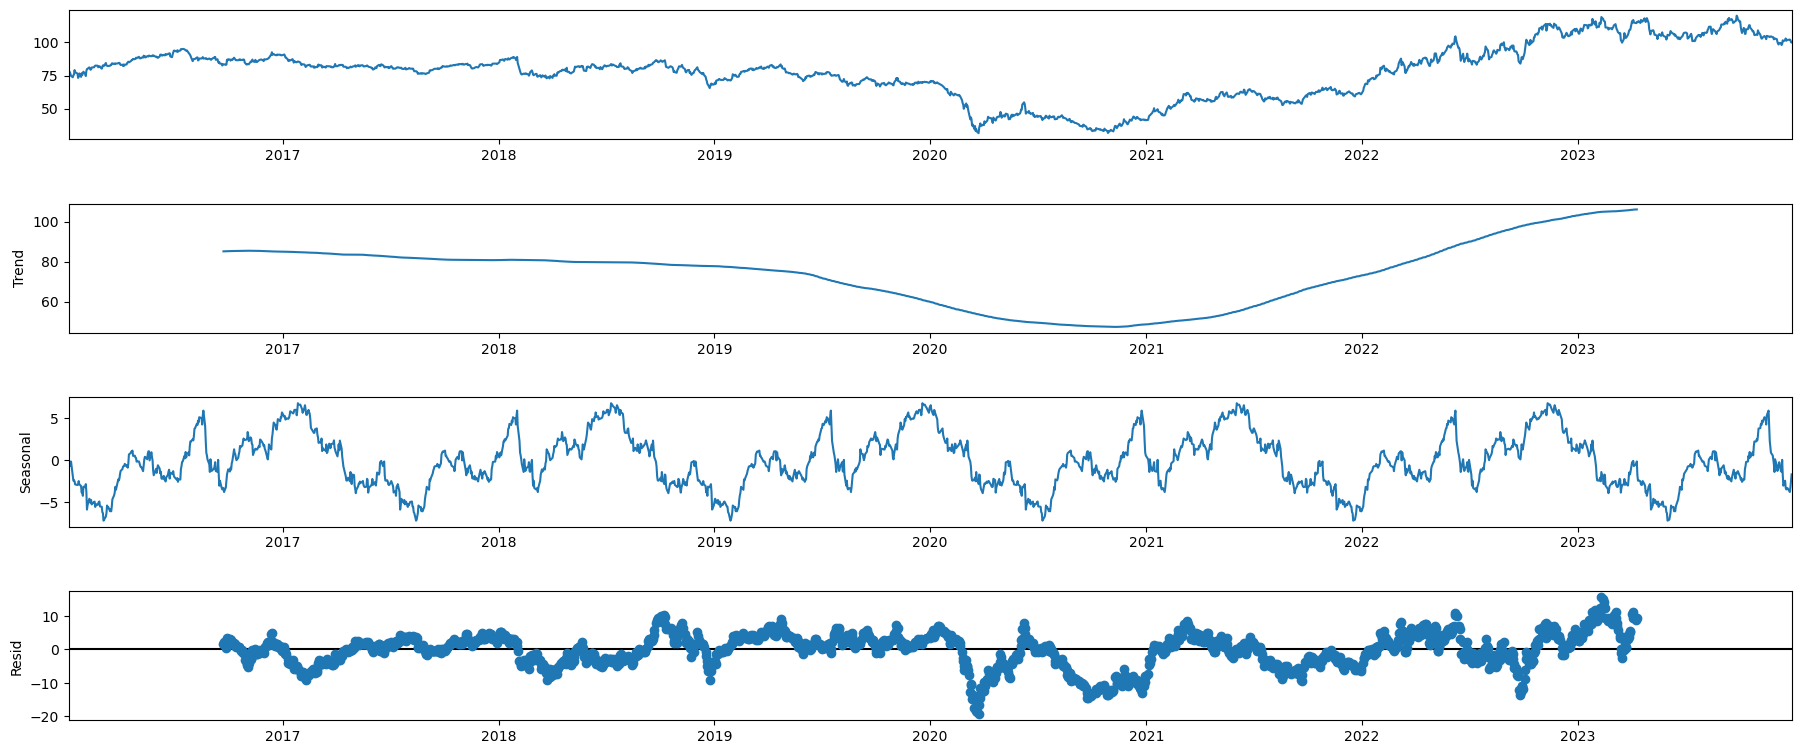

In [52]:
df_close = df[['date', 'PRC']].copy()
df_close = df_close.set_index('date')
df_close.head()

decomp = seasonal_decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

In [53]:
df['EMA_9'] = df['PRC'].ewm(9).mean().shift()
df['SMA_5'] = df['PRC'].rolling(5).mean().shift()
df['SMA_10'] = df['PRC'].rolling(10).mean().shift()
df['SMA_15'] = df['PRC'].rolling(15).mean().shift()
df['SMA_30'] = df['PRC'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.date, y=df.PRC, name='PRC', opacity=0.2))
fig.show()


In [54]:
def relative_strength_idx(df, n=14):
    close = df['PRC']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.date, y=df.RSI, name='RSI'))
fig.show()

In [55]:
EMA_12 = pd.Series(df['PRC'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['PRC'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.date, y=df.PRC, name='PRC'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [56]:
df['PRC'] = df['PRC'].shift(-1)

In [57]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

In [63]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.date, y=train_df.PRC, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.date, y=valid_df.PRC, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.date,  y=test_df.PRC,  name='Test'))
fig.show()

In [64]:
drop_cols = ['date', 'VOL', 'BIDLO', 'ASKHI', 'RET', 'OPENPRC', 'TICKER', 'PERMNO']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

In [65]:
y_train = train_df['PRC'].copy()
X_train = train_df.drop(['PRC'], 1)

y_valid = valid_df['PRC'].copy()
X_valid = valid_df.drop(['PRC'], 1)

y_test  = test_df['PRC'].copy()
X_test  = test_df.drop(['PRC'], 1)

X_train.info()
X_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1385 entries, 0 to 1384
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        1385 non-null   float64
 1   SMA_5        1385 non-null   float64
 2   SMA_10       1385 non-null   float64
 3   SMA_15       1385 non-null   float64
 4   SMA_30       1385 non-null   float64
 5   RSI          1385 non-null   float64
 6   MACD         1385 non-null   float64
 7   MACD_signal  1385 non-null   float64
dtypes: float64(8)
memory usage: 86.7 KB


,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,79.706380,81.840,80.947,79.767333,77.729333,72.863568,1.359215,1.179398
1,79.982419,82.112,81.178,80.070000,77.934667,75.937500,1.281649,1.202308
2,80.110380,82.114,81.185,80.399333,78.152667,66.521739,1.228025,1.207935
3,80.254591,82.018,81.329,80.861333,78.413667,63.069544,1.208956,1.208154
4,80.433765,81.930,81.595,81.096667,78.640667,60.000000,1.160419,1.198052


In [67]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[12:42:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[12:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[12:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[12:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[12:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { 

KeyboardInterrupt: 